Проект посвящен задаче многоклассовой классификации изображений, данные доступны[по сслыке](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 52.0 MB/s eta 0:00:00


In [ ]:
import math
import os
import random
import sys
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import torch.optim as optim
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

from torchvision.transforms import ToTensor
import multiprocessing

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-12 17:45:14--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-12 17:45:14--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc56a5a9a43d0ea1cae900759bf4.dl.dropboxusercontent.com/cd/0/get/CHY1tZ9mfieXfEi9N3iFuYb6--VBltl9rIm0UHqR4zBvuzpgQ-4vBnhZayX6bv4komZpRMiKaMy-YIG1RXg5M_XTEChpO82AQzYuGhrnwDoWKIbqdp-65wgLuE9-AnRfj5B1NtfarvVEdpNpWdwSezbd/file?dl=1# [following]
--2023-11-12 17:45:14--  https://uc56a5a9a43d0ea1cae900759bf4.dl.dropboxusercontent.com/cd/0/get/CHY1tZ9mfieXfEi9N3iFuYb6--VBltl9rIm0UHqR4zBvuzpgQ-4vBnhZayX6bv4komZpRMiKaMy-YIG1RXg5M_XTEChpO82AQzYuGhr

In [ ]:
data_path = '/content/dataset/dataset/train'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='/content/dataset/dataset/train', transform=transform)
test_dataset = ImageFolder(root='/content/dataset/dataset/val', transform=transform)

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

combined_loader = torch.utils.data.DataLoader(combined_dataset)

mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0

for data, _ in combined_loader:
    batch_samples = data.size(0)
    channels = data.size(1)
    height = data.size(2)
    width = data.size(3)
    data = data.view(batch_samples, channels, -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print("Средние значения по каналам:", mean)
print("Стандартные отклонения по каналам:", std)

Средние значения по каналам: tensor([0.4804, 0.4482, 0.3976])
Стандартные отклонения по каналам: tensor([0.2296, 0.2263, 0.2255])


### Делаем аугментацию

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4804, 0.4482, 0.3976], std=[0.2296, 0.2263, 0.2255])
])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=transform)
test_dataset = ImageFolder('/content/dataset/dataset/val', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)


### Подготовим данные к обучению

In [ ]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Изучим изображения

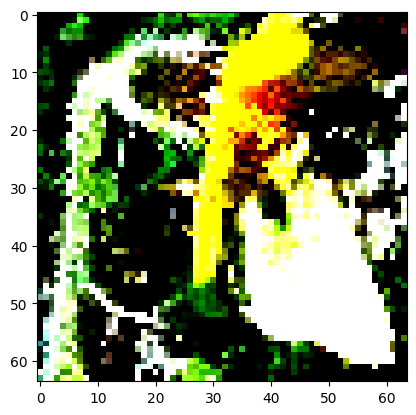

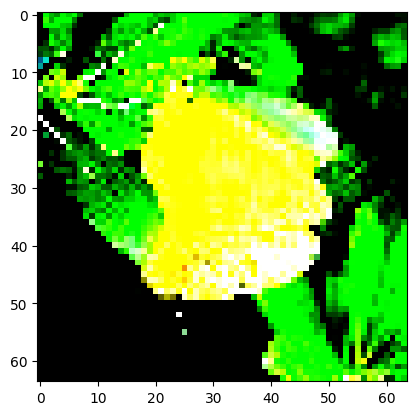

In [ ]:
for batch in test_loader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

В результате прочтения обзорной статьи выбор пал на MobileNet архитектуру, поскольку она имхо оптимальна по скорости обучения и выдаваемому качеству. Также были опробованы классическая Resnet и она же со слоями из NeuralODE. Resnet довольно долго обучаема с качеством, которое меня не устроило, все же макспулинги долго работают. Качество Resnet and NeuralODE выдавалось почти идеальным, в границах 0.93 accuracy на 4 эпохах, но тренировка шла несколько часов на 48 ядрах. Этот опыт был интересен мне и использовался для иных научных задачах, в колабе такие тяжелые модели тренирвоать не выйдет. Опыты с оптимизаторами я проводил, использую Adam.

# Запускаем не предобученную архитектуру

In [ ]:
class MobileNet_not_pretrained(pl.LightningModule):
    def __init__(self):
        super(MobileNet_not_pretrained, self).__init__()
        self.model = models.mobilenet_v3_large(weights=None, num_classes=200)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=3.86e-03)
        return optimizer

    def train_dataloader(self):
        train_dataset = ImageFolder(root='/content/dataset/dataset/train', transform=transform)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        return train_loader

In [ ]:
model = MobileNet_not_pretrained().to(device)

wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning

trainer = pl.Trainer(logger=wandb_logger)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNetV3      | 4.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.833    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to i

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# Найдем оптимальный шаг обучения

In [ ]:
!pip install torch_lr_finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.68E-03


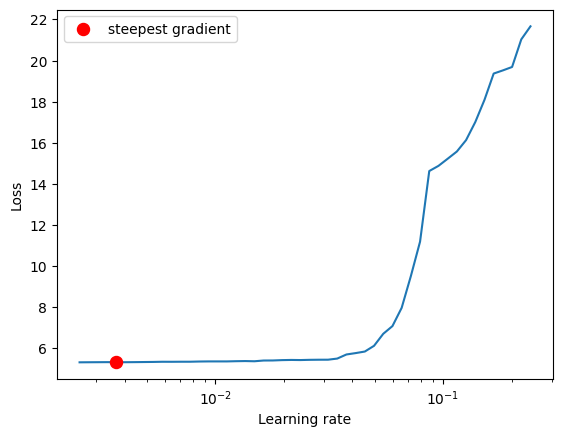

In [ ]:
from torch_lr_finder import LRFinder
import torch.optim as optim
import torchvision.models as models

model = MobileNet_not_pretrained().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()

### Тренируем модель, для большей скорости понимания "толковости" модели тренировочный датасет ужимался в 10 раз, но это останется за кадром.

In [ ]:
model = MobileNet_not_pretrained().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.86e-03)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    correct = 0

    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}, Loss: {correct / len(train_loader)}")

    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_loader)
    print(f'Accuracy on test data: {accuracy:.2f}')

print(f"Оценка за это задание составит: {np.clip(10 * accuracy / 0.44, 0, 10):.2f}")

weights_path_1 = "model_nopretrain_weights.pt"

# Сохранение весов модели
torch.save(model.state_dict(), weights_path_1)


0it [00:00, ?it/s]
1it [00:02,  2.26s/it]
2it [00:04,  2.19s/it]
3it [00:06,  2.18s/it]
4it [00:08,  2.18s/it]
5it [00:10,  2.00s/it]
6it [00:11,  1.80s/it]
7it [00:13,  1.67s/it]
8it [00:14,  1.57s/it]
9it [00:16,  1.53s/it]
10it [00:17,  1.48s/it]
11it [00:18,  1.45s/it]
12it [00:20,  1.51s/it]
13it [00:22,  1.73s/it]
14it [00:24,  1.85s/it]
15it [00:26,  1.94s/it]
16it [00:29,  2.00s/it]
17it [00:31,  2.15s/it]
18it [00:33,  2.05s/it]
19it [00:35,  2.05s/it]
20it [00:37,  1.91s/it]
21it [00:38,  1.90s/it]
22it [00:40,  1.83s/it]
23it [00:44,  2.39s/it]
24it [00:47,  2.79s/it]
25it [00:51,  2.93s/it]
26it [00:54,  3.01s/it]
27it [00:56,  2.72s/it]
28it [00:58,  2.50s/it]
29it [01:00,  2.37s/it]
30it [01:02,  2.24s/it]
31it [01:05,  2.46s/it]
32it [01:08,  2.65s/it]
33it [01:10,  2.49s/it]
34it [01:12,  2.39s/it]
35it [01:14,  2.29s/it]
36it [01:16,  2.01s/it]
37it [01:17,  1.82s/it]
38it [01:18,  1.69s/it]
39it [01:20,  1.59s/it]
40it [01:21,  1.55s/it]
41it [01:23,  1.50s/it]
42it 

Epoch 1, Loss: 0.49039692701664533



100%|██████████| 156/156 [00:48<00:00,  3.19it/s]


Accuracy on test data: 0.40



0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.42s/it]
4it [00:05,  1.40s/it]
5it [00:06,  1.40s/it]
6it [00:08,  1.57s/it]
7it [00:11,  1.77s/it]
8it [00:13,  1.90s/it]
9it [00:15,  1.98s/it]
10it [00:17,  2.03s/it]
11it [00:19,  1.96s/it]
12it [00:20,  1.79s/it]
13it [00:22,  1.66s/it]
14it [00:23,  1.57s/it]
15it [00:24,  1.51s/it]
16it [00:26,  1.47s/it]
17it [00:27,  1.45s/it]
18it [00:29,  1.45s/it]
19it [00:31,  1.67s/it]
20it [00:33,  1.82s/it]
21it [00:35,  1.92s/it]
22it [00:37,  1.99s/it]
23it [00:39,  2.05s/it]
24it [00:41,  1.86s/it]
25it [00:42,  1.71s/it]
26it [00:44,  1.60s/it]
27it [00:45,  1.53s/it]
28it [00:46,  1.48s/it]
29it [00:48,  1.44s/it]
30it [00:49,  1.43s/it]
31it [00:51,  1.56s/it]
32it [00:53,  1.76s/it]
33it [00:55,  1.88s/it]
34it [00:57,  1.97s/it]
35it [01:00,  2.02s/it]
36it [01:01,  1.94s/it]
37it [01:03,  1.77s/it]
38it [01:04,  1.66s/it]
39it [01:05,  1.57s/it]
40it [01:07,  1.52s/it]
41it [01:08,  1.47s/it]
42it 

Epoch 2, Loss: 0.5717029449423816



100%|██████████| 156/156 [00:49<00:00,  3.13it/s]

Accuracy on test data: 0.70
Оценка за это задание составит: 10.00


### Тренировочный класс lightning

Будем использовать предобученую модель MobileNet, она весьма успешно показала себя

In [ ]:
class MobileNet_pretrained(pl.LightningModule):
    def __init__(self):
        super(MobileNet_pretrained, self).__init__()
        self.model = models.mobilenet_v3_large(num_classes=200)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=3.86e-03)
        return optimizer

    def train_dataloader(self):
        train_dataset = ImageFolder(root='/content/dataset/dataset/train', transform=transform)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        return train_loader

In [ ]:
model_2 = MobileNet_pretrained().to(device)

wandb_logger_2 = WandbLogger(log_model='all')

trainer_2 = pl.Trainer(logger=wandb_logger_2)
trainer.fit(model_2)

### Валидация результатов

In [ ]:
model = MobileNet_pretrained().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.86e-03)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    correct = 0

    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}, Loss: {correct / len(train_loader)}")

    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_loader)
    print(f'Accuracy on test data: {accuracy:.2f}')

print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

weights_path_2 = "model_pretrain_weights.pt"
torch.save(model.state_dict(), weights_path_2)


0it [00:00, ?it/s]
1it [00:01,  1.92s/it]
2it [00:03,  1.60s/it]
3it [00:04,  1.49s/it]
4it [00:06,  1.44s/it]
5it [00:07,  1.42s/it]
6it [00:08,  1.40s/it]
7it [00:10,  1.38s/it]
8it [00:11,  1.39s/it]
9it [00:13,  1.63s/it]
10it [00:15,  1.79s/it]
11it [00:17,  1.89s/it]
12it [00:20,  1.96s/it]
13it [00:22,  2.01s/it]
14it [00:23,  1.88s/it]
15it [00:25,  1.72s/it]
16it [00:26,  1.61s/it]
17it [00:27,  1.53s/it]
18it [00:29,  1.48s/it]
19it [00:30,  1.44s/it]
20it [00:31,  1.41s/it]
21it [00:33,  1.46s/it]
22it [00:35,  1.69s/it]
23it [00:37,  1.83s/it]
24it [00:39,  1.92s/it]
25it [00:42,  1.98s/it]
26it [00:44,  2.02s/it]
27it [00:45,  1.82s/it]
28it [00:46,  1.69s/it]
29it [00:48,  1.59s/it]
30it [00:49,  1.52s/it]
31it [00:50,  1.47s/it]
32it [00:52,  1.44s/it]
33it [00:53,  1.42s/it]
34it [00:55,  1.60s/it]
35it [00:57,  1.76s/it]
36it [01:00,  1.88s/it]
37it [01:02,  1.95s/it]
38it [01:04,  2.00s/it]
39it [01:05,  1.92s/it]
40it [01:07,  1.75s/it]
41it [01:08,  1.64s/it]
42it 

Epoch 1, Loss: 0.4852752880921895



100%|██████████| 156/156 [00:48<00:00,  3.20it/s]


Accuracy on test data: 0.64



0it [00:00, ?it/s]
1it [00:02,  2.15s/it]
2it [00:03,  1.97s/it]
3it [00:05,  1.70s/it]
4it [00:06,  1.58s/it]
5it [00:08,  1.51s/it]
6it [00:09,  1.46s/it]
7it [00:10,  1.44s/it]
8it [00:12,  1.42s/it]
9it [00:13,  1.44s/it]
10it [00:16,  1.68s/it]
11it [00:18,  1.84s/it]
12it [00:20,  1.93s/it]
13it [00:22,  1.99s/it]
14it [00:24,  2.03s/it]
15it [00:26,  1.86s/it]
16it [00:27,  1.71s/it]
17it [00:28,  1.62s/it]
18it [00:30,  1.55s/it]
19it [00:31,  1.50s/it]
20it [00:32,  1.46s/it]
21it [00:34,  1.44s/it]
22it [00:36,  1.61s/it]
23it [00:38,  1.79s/it]
24it [00:40,  1.90s/it]
25it [00:42,  1.97s/it]
26it [00:45,  2.02s/it]
27it [00:46,  1.94s/it]
28it [00:48,  1.77s/it]
29it [00:49,  1.65s/it]
30it [00:50,  1.58s/it]
31it [00:52,  1.53s/it]
32it [00:53,  1.49s/it]
33it [00:55,  1.45s/it]
34it [00:56,  1.49s/it]
35it [00:58,  1.70s/it]
36it [01:01,  1.85s/it]
37it [01:03,  1.93s/it]
38it [01:05,  2.01s/it]
39it [01:07,  2.03s/it]
40it [01:08,  1.83s/it]
41it [01:10,  1.70s/it]
42it 

Epoch 2, Loss: 0.5659411011523687



100%|██████████| 156/156 [00:49<00:00,  3.16it/s]


Accuracy on test data: 0.46



0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:02,  1.39s/it]
3it [00:04,  1.38s/it]
4it [00:05,  1.38s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.39s/it]
7it [00:09,  1.39s/it]
8it [00:11,  1.64s/it]
9it [00:14,  1.81s/it]
10it [00:16,  1.91s/it]
11it [00:18,  1.98s/it]
12it [00:20,  1.89s/it]
13it [00:21,  1.73s/it]
14it [00:22,  1.61s/it]
15it [00:24,  1.54s/it]
16it [00:25,  1.49s/it]
17it [00:26,  1.46s/it]
18it [00:28,  1.44s/it]
19it [00:29,  1.49s/it]
20it [00:32,  1.70s/it]
21it [00:34,  1.83s/it]
22it [00:36,  1.97s/it]
23it [00:38,  2.12s/it]
24it [00:40,  1.90s/it]
25it [00:41,  1.74s/it]
26it [00:43,  1.63s/it]
27it [00:44,  1.55s/it]
28it [00:45,  1.50s/it]
29it [00:47,  1.46s/it]
30it [00:48,  1.44s/it]
31it [00:50,  1.59s/it]
32it [00:52,  1.75s/it]
33it [00:54,  1.87s/it]
34it [00:56,  1.95s/it]
35it [00:58,  1.97s/it]
36it [01:00,  1.78s/it]
37it [01:01,  1.66s/it]
38it [01:03,  1.57s/it]
39it [01:04,  1.51s/it]
40it [01:05,  1.47s/it]
41it [01:07,  1.44s/it]
42it 

Epoch 3, Loss: 0.8092189500640204



100%|██████████| 156/156 [00:47<00:00,  3.25it/s]

Accuracy on test data: 0.97
Оценка за это задание составит 10.00 баллов


Эксперименты проводились с выбором известной архитектуры для обучения, например, с Resnet и Resnet+NeuralODE, но они слишком долго учились, поэтому изучил обзорную статью про архитектуры классификации и взял MobileNet, которая показалась оптимальной по времени работы и качеству.